In [1]:
!pip install fastbook -Uqq
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
import os 

In [2]:
##!pip install exif_delete # Delete possibly corrupt metadata from images. 


Check out a paper that does something similar:

Using CNN to Classify and Understand Artists from the Rijksmuseum
http://cs231n.stanford.edu/reports/2017/pdfs/410.pdf


##Gathering our data

In [3]:
if not os.path.isdir("images"):
  dir = "images"
  os.mkdir(dir)
key = os.environ.get("AZURE_SEARCH_KEY", "20b8ca010aa84b1eb2434bcd5b50d56c")

In [4]:
results = search_images_bing(key, 'van gogh paintings')
ims = results.attrgot('contentUrl')
dest = 'images/vangogh'
download_url(ims[0], dest)

# im = Image.open(dest)
# im.to_thumb(128, 128)

In [5]:
# artists = ["Vincent Van Gogh", 
#            "Pablo Picasso", 
#            "Frida Kahlo", 
#            "Jackson Pollock", 
#            "Salvador Dali ", 
#            "Francis Bacon", 
#            "Andy Warhol"]

artists = ["Vincent Van Gogh", 
           "Pablo Picasso", 
           "Frida Kahlo", 
           "Jackson Pollock",  
           "Andy Warhol"]
           
path = Path("artists")

In [6]:
if not path.exists():
  path.mkdir()
for e in artists:
  dest = path/e
  dest.mkdir(exist_ok=true)
  results = search_images_bing(key, f'paintings by {e}')
  results
  download_images(dest, urls=results.attrgot('contentUrl'))

In [7]:
fns = get_image_files(path)
# for i in fns:
#   image_file = open(i)
#   image = Image.open(image_file)

#   # next 3 lines strip exif
#   image_data = list(image.getdata())
#   image_without_exif = Image.new(image.mode, image.size)
#   image_without_exif.putdata(image_data)

#   image_without_exif.save(u"clean_{}".format(image_filename))
fns

(#762) [Path('artists/Vincent Van Gogh/00000000.jpg'),Path('artists/Vincent Van Gogh/00000005.jpg'),Path('artists/Vincent Van Gogh/00000008.jpg'),Path('artists/Vincent Van Gogh/00000009.jpg'),Path('artists/Vincent Van Gogh/00000004.jpg'),Path('artists/Vincent Van Gogh/00000006.jpg'),Path('artists/Vincent Van Gogh/00000001.jpg'),Path('artists/Vincent Van Gogh/00000003.jpg'),Path('artists/Vincent Van Gogh/00000002.jpg'),Path('artists/Vincent Van Gogh/00000010.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#5) [Path('artists/Pablo Picasso/00000033.jpg'),Path('artists/Pablo Picasso/00000071.jpg'),Path('artists/Frida Kahlo/00000063.jpg'),Path('artists/Jackson Pollock/00000030.jpg'),Path('artists/Andy Warhol/00000057.jpg')]

In [9]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

In [10]:
paintings = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(128)
)

In [11]:
dls = paintings.dataloaders(path)

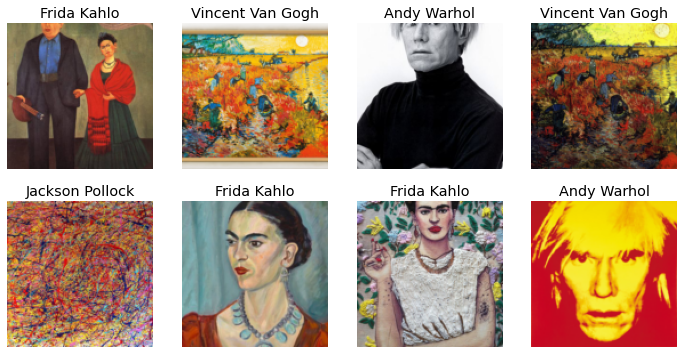

In [12]:
dls.valid.show_batch(nrows=2, max_n=8)

In [13]:
paintings = paintings.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = paintings.dataloaders(path)

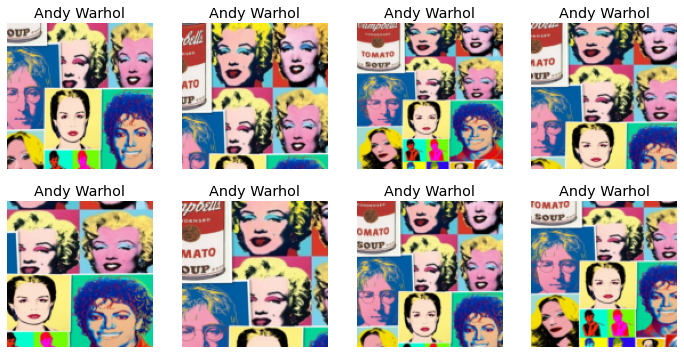

In [14]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

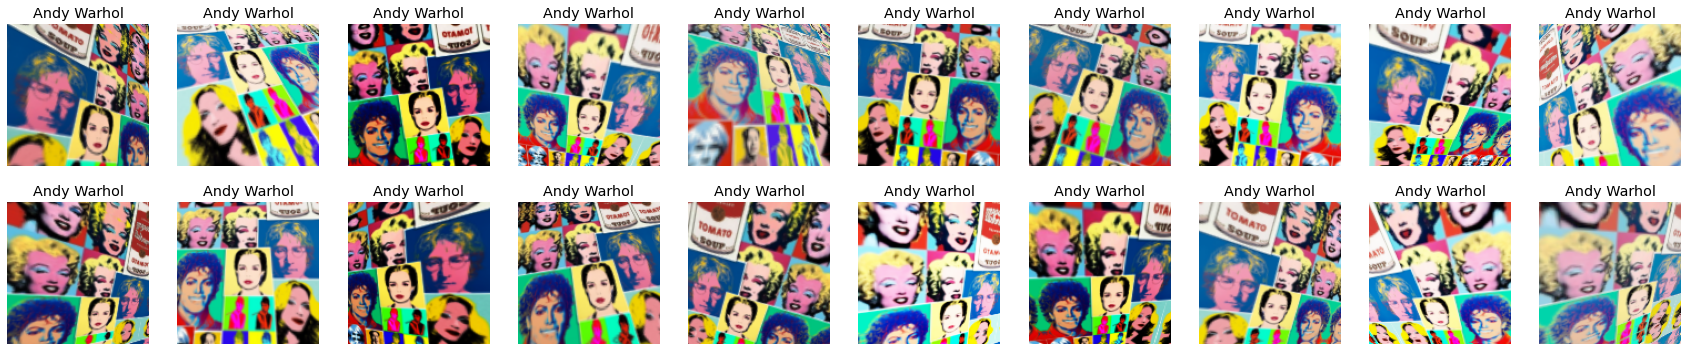

In [15]:
paintings = paintings.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = paintings.dataloaders(path)
dls.train.show_batch(max_n=20, nrows=2, unique=True)

In [16]:
paintings = paintings.new(item_tfms=Resize(128, ResizeMethod.Squish))

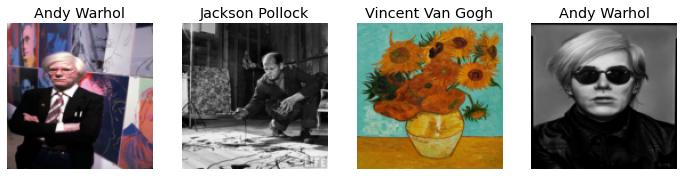

In [17]:
dls = paintings.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

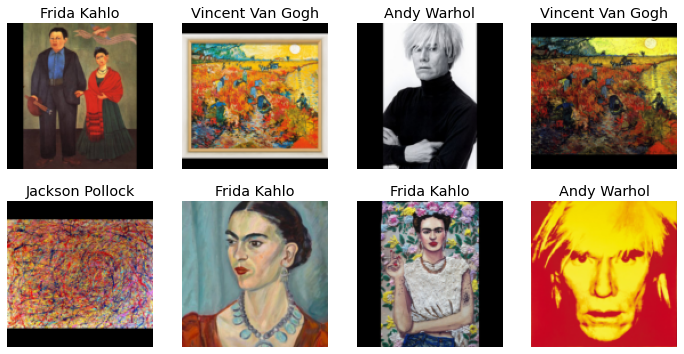

In [18]:
paintings = paintings.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = paintings.dataloaders(path)
dls.valid.show_batch(nrows=2, max_n=8)

##Training a model and using it to clean our data

In [19]:

paintings = paintings.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = paintings.dataloaders(path)

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn

In [21]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.228733,1.265779,0.331126,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.774729,0.526932,0.152318,00:11
1,0.617657,0.450557,0.105960,00:10
2,0.488503,0.432111,0.105960,00:10
3,0.407639,0.403056,0.105960,00:10


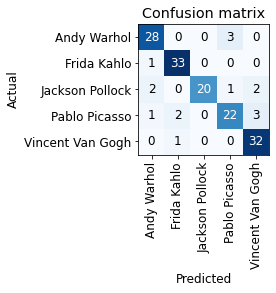

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

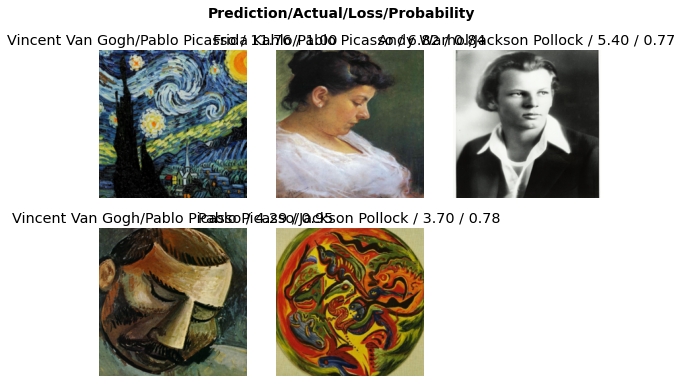

In [23]:
interp.plot_top_losses(5)

In [39]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [42]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

##Turning our model into a web app

In [43]:
learn.export()
path=Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [44]:
model_inf= load_learner(path/'export.pkl')

In [45]:
#model_inf.predict()

In [46]:
model_inf.dls.vocab

['Andy Warhol', 'Frida Kahlo', 'Jackson Pollock', 'Pablo Picasso', 'Vincent Van Gogh']

## Creating a notebook app

In [30]:
btn_upload=FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [47]:
img = PILImage.create(btn_upload.data[-1])

In [48]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [49]:
pred, pred_idx,probs=model_inf.predict(img)

In [50]:
lbl_pred= widgets.Label()
lbl_pred.value = f'Prediction {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction Vincent Van Gogh; Probability: 0.9997')

In [51]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [55]:

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = model_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [56]:
btn_upload = widgets.FileUpload()


In [57]:
VBox([widgets.Label('Upload an artist.'), 
      btn_upload, btn_run, out_pl, lbl_pred])

NameError: name 'learn_inf' is not defined

In [35]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 1.9 MB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 188 kB 65.7 MB/s eta 0:00:01
     |████████████████████████████████| 552 kB 83.7 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 4.4 MB/s  eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.6 OK
